In [793]:
import os
import pickle
import matplotlib
import numpy as np
import typing as t
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from v1t.utils import utils, tensorboard

utils.set_random_seed(1234)

tensorboard.set_font()
IMAGE_SIZE = (1, 36, 64)

In [794]:
def Gaussian2d(
    xy: np.ndarray,
    amplitude: float,
    xo: float,
    yo: float,
    sigma_x: float,
    sigma_y: float,
    theta: float,
    offset: float,
):

    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x**2) + (np.sin(theta) ** 2) / (
        2 * sigma_y**2
    )
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (
        4 * sigma_y**2
    )
    c = (np.sin(theta) ** 2) / (2 * sigma_x**2) + (np.cos(theta) ** 2) / (
        2 * sigma_y**2
    )
    g = offset + amplitude * np.exp(
        -(a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2))
    )
    return g.ravel()

In [795]:
MOUSE_ID = "A"
COLORMAP = "turbo"
CMAP = matplotlib.colormaps.get_cmap(COLORMAP)
COLORS = CMAP(np.arange(256))[:, :3]
LABEL_FONTSIZE, TICK_FONTSIZE = 8, 6

In [796]:
def plot_overlay(
    axis: matplotlib.axes.Axes,
    image: np.ndarray,
    heatmap: np.ndarray,
    behavior: np.ndarray,
    pupil_center: np.ndarray,
    alpha: float = 0.5,
):
    image = image[0]
    heatmap = COLORS[np.uint8(255.0 * heatmap)] * 255.0
    heatmap = alpha * heatmap + (1 - alpha) * image[..., None]
    axis.imshow(heatmap.astype(np.uint8), cmap=COLORMAP)
    axis.set_xticks([])
    axis.set_yticks([])
    tensorboard.remove_spines(axis=axis)
    description = (
        f"[{behavior[0]:.01f}, "  # pupil dilation
        f"{behavior[1]:.01f}, "  # dilation derivative
        f"({pupil_center[0]:.01f}, {pupil_center[1]:.01f}), "  # pupil center
        f"{behavior[2]:.01f}]"  # speed
    )
    axis.set_xlabel(description, labelpad=2, fontsize=TICK_FONTSIZE + 1)


def plot_attention_maps(
    figure: matplotlib.figure.Figure,
    attention_maps: t.Dict[str, t.Dict[str, t.Dict[str, np.ndarray]]],
):
    width, height, wspace = 0.4, 0.3, -0.08
    ax1 = figure.add_axes(rect=[0, 0, width, height])
    plot_overlay(
        axis=ax1,
        image=attention_maps["validation"][MOUSE_ID]["images"][0],
        heatmap=attention_maps["validation"][MOUSE_ID]["heatmaps"][0],
        behavior=attention_maps["validation"][MOUSE_ID]["behaviors"][0],
        pupil_center=attention_maps["validation"][MOUSE_ID]["pupil_centers"][0],
    )
    pos1 = ax1.get_position()
    title_position = pos1.y1 + 0.01

    figure.text(
        x=(pos1.x0 + pos1.x1) / 2,
        y=title_position,
        s="Validation sample",
        fontsize=LABEL_FONTSIZE,
        ha="center",
    )
    ax2 = figure.add_axes(rect=[pos1.x1 + wspace, 0, width, height])
    plot_overlay(
        axis=ax2,
        image=attention_maps["test"][MOUSE_ID]["images"][0],
        heatmap=attention_maps["test"][MOUSE_ID]["heatmaps"][0],
        behavior=attention_maps["test"][MOUSE_ID]["behaviors"][0],
        pupil_center=attention_maps["test"][MOUSE_ID]["pupil_centers"][0],
    )
    pos2 = ax2.get_position()
    ax3 = figure.add_axes(rect=[pos2.x1 + wspace, 0, width, height])
    plot_overlay(
        axis=ax3,
        image=attention_maps["test"][MOUSE_ID]["images"][1],
        heatmap=attention_maps["test"][MOUSE_ID]["heatmaps"][1],
        behavior=attention_maps["test"][MOUSE_ID]["behaviors"][1],
        pupil_center=attention_maps["test"][MOUSE_ID]["pupil_centers"][1],
    )
    pos3 = ax3.get_position()

    figure.text(
        x=(pos2.x0 + pos3.x1) / 2,
        y=title_position,
        s="Test samples",
        fontsize=LABEL_FONTSIZE,
        ha="center",
    )

    # plot colorbar
    width, height = 0.007, (pos3.y1 - pos3.y0) * 0.35
    cbar_ax = figure.add_axes(
        rect=[
            pos3.x1 + 0.005,
            ((pos3.y1 - pos3.y0) / 2 + pos3.y0) - (height / 2),
            width,
            height,
        ]
    )
    plt.colorbar(
        cm.ScalarMappable(cmap=COLORMAP),
        cax=cbar_ax,
        shrink=0.5,
    )
    tensorboard.set_yticks(
        axis=cbar_ax,
        ticks_loc=np.linspace(0, 1, 2).astype(int),
        tick_fontsize=TICK_FONTSIZE,
    )
    tensorboard.set_ticks_params(axis=cbar_ax, length=1, pad=1)

    return [pos1, pos2, pos3]

In [797]:
normalize = lambda a: (a - a.min()) / (a.max() - a.min())


def plot_aRF(axis, aRF: np.ndarray, parameter: np.ndarray, title: str = None):
    height, width = aRF.shape[1], aRF.shape[2]
    x, y = np.linspace(0, width, width), np.linspace(0, height, height)
    x, y = np.meshgrid(x, y)
    axis.imshow(normalize(aRF[0]), cmap="gray", vmin=0, vmax=1)
    fitted = Gaussian2d((x, y), *parameter)
    fitted = fitted.reshape(height, width)
    axis.contour(
        x,
        y,
        fitted,
        levels=[1],
        alpha=0.8,
        linewidths=2,
        colors="orangered",
    )
    if title is not None:
        axis.set_xlabel(title, labelpad=1, fontsize=LABEL_FONTSIZE)
    axis.set_xticks([])
    axis.set_yticks([])
    tensorboard.remove_spines(axis=axis)


def load_sigmas(popts: np.ndarray):
    x, y = popts[:, 3], popts[:, 4]
    x, y = np.abs(x[~np.isnan(x)]), np.abs(y[~np.isnan(y)])
    return x, y


def plot_aRFs(
    figure: matplotlib.figure.Figure,
    cnn_results: t.Dict[str, np.ndarray],
    vit_results: t.Dict[str, np.ndarray],
    top_pos: t.List[matplotlib.transforms.Bbox],
    unit: int,
):
    width, height, top = 0.18, 0.3, -0.38

    ax1 = figure.add_axes(rect=[top_pos[0].x0, top, width, height])

    plot_aRF(
        axis=ax1,
        aRF=cnn_results["aRFs"][unit],
        parameter=cnn_results["popts"][unit],
        title=f"CNN",
    )
    pos1 = ax1.get_position()
    ax2 = figure.add_axes(rect=[pos1.x1, top, width, height])
    plot_aRF(
        axis=ax2,
        aRF=vit_results["aRFs"][unit],
        parameter=vit_results["popts"][unit],
        title=f"ViT",
    )
    pos2 = ax2.get_position()

    ###### PLOT GAUSSIAN DISTRIBUTIONS ######
    alpha = 0.7
    x_max = 8
    y_max = 2000
    linewidth = 0.5
    bins = np.linspace(0, x_max, 30)

    cnn_sigma_x, cnn_sigma_y = load_sigmas(cnn_results["popts"])
    vit_sigma_x, vit_sigma_y = load_sigmas(vit_results["popts"])

    width, height, offset = 0.165, 0.195, 0.07
    ax3 = figure.add_axes(rect=[pos2.x1 + 0.035, top + offset, width, height])
    ax3.hist(
        cnn_sigma_x,
        bins=bins,
        alpha=alpha,
        linewidth=linewidth,
        color="dodgerblue",
        label="CNN",
    )
    ax3.hist(
        vit_sigma_x,
        bins=bins,
        alpha=alpha,
        linewidth=linewidth,
        color="orangered",
        label="ViT",
    )
    pos3 = ax3.get_position()

    ax4 = figure.add_axes(rect=[pos3.x1, top + offset, width, height])
    ax4.hist(
        cnn_sigma_y,
        bins=bins,
        alpha=alpha,
        linewidth=linewidth,
        color="dodgerblue",
        label="CNN",
    )
    ax4.hist(
        vit_sigma_y,
        bins=bins,
        alpha=alpha,
        linewidth=linewidth,
        color="orangered",
        label="ViT",
    )
    pos4 = ax4.get_position()

    x_range = np.linspace(0, x_max, 5)
    y_range = np.linspace(0, y_max, 3)

    tensorboard.set_xticks(
        axis=ax3,
        ticks_loc=x_range,
        ticks=x_range.astype(int),
        tick_fontsize=TICK_FONTSIZE,
    )
    ax3.set_xlabel("x (px)", fontsize=TICK_FONTSIZE + 1, labelpad=0)
    tensorboard.set_yticks(
        axis=ax3,
        ticks_loc=y_range,
        ticks=[0, "1k", "2k"],
        tick_fontsize=TICK_FONTSIZE,
    )
    ax3.set_ylabel("Count", fontsize=TICK_FONTSIZE + 1, labelpad=0)

    tensorboard.set_xticks(
        axis=ax4,
        ticks_loc=x_range,
        ticks=x_range.astype(int),
        tick_fontsize=TICK_FONTSIZE,
    )
    ax4.set_xlabel("y (px)", fontsize=TICK_FONTSIZE + 1, labelpad=0)
    ax4.set_yticks([])
    ax4.set_ylim(0, y_max)
    tensorboard.set_ticks_params(axis=ax3, length=2, pad=1)
    tensorboard.set_ticks_params(axis=ax4, length=2, pad=1)

    ax4.legend(
        loc="upper right",
        bbox_to_anchor=(0.98, 1.1),
        ncols=2,
        frameon=False,
        handletextpad=0.35,
        handlelength=0.6,
        markerscale=0.8,
        columnspacing=0.85,
        fontsize=TICK_FONTSIZE,
    )

    sns.despine(ax=ax3, top=True, right=True, trim=True)
    sns.despine(ax=ax4, top=True, right=True, left=True, trim=True)

    return [pos1, pos2, pos3, pos4]

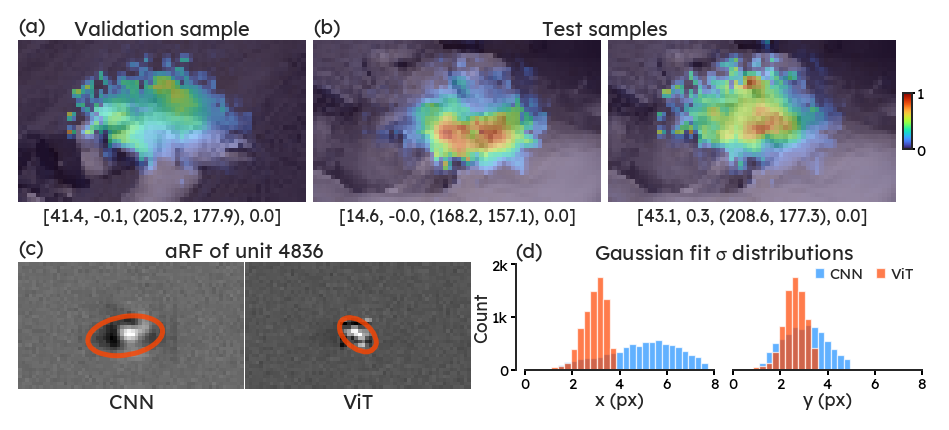

In [798]:
with open("../runs/best_v1t_sensorium/attention_rollout_maps.pkl", "rb") as file:
    attention_maps = pickle.load(file)

with open("../runs/sensorium/023_stacked2d_gaussian2d_bm0/aRFs.pkl", "rb") as file:
    cnn_results = pickle.load(file)

with open("../runs/sensorium/026_vit_gaussian2d_bm0/aRFs.pkl", "rb") as file:
    vit_results = pickle.load(file)

figure = plt.figure(figsize=(7, 3), dpi=180)
unit = 4836
top_pos = plot_attention_maps(figure=figure, attention_maps=attention_maps)
bottom_pos = plot_aRFs(
    figure=figure,
    cnn_results=cnn_results,
    vit_results=vit_results,
    top_pos=top_pos,
    unit=unit,
)

figure.text(
    x=top_pos[1].x0,
    y=top_pos[1].y1 + 0.015,
    s="(b)",
    fontsize=LABEL_FONTSIZE,
    ha="left",
)
figure.text(
    x=top_pos[0].x0,
    y=top_pos[0].y1 + 0.015,
    s="(a)",
    fontsize=LABEL_FONTSIZE,
    ha="left",
)

figure.text(
    x=bottom_pos[0].x0,
    y=bottom_pos[0].y1 + 0.015,
    s="(c)",
    fontsize=LABEL_FONTSIZE,
    ha="left",
)
figure.text(
    x=(bottom_pos[0].x0 + bottom_pos[1].x1) / 2,
    y=bottom_pos[0].y1 + 0.01,
    s="aRF of unit 4836",
    fontsize=LABEL_FONTSIZE,
    ha="center",
)


figure.text(
    x=bottom_pos[2].x0,
    y=bottom_pos[2].y1 + 0.015,
    s="(d)",
    fontsize=LABEL_FONTSIZE,
    ha="left",
)
figure.text(
    x=(bottom_pos[2].x0 + bottom_pos[3].x1) / 2,
    y=bottom_pos[2].y1 + 0.01,
    s=f"Gaussian fit $\sigma$ distributions",
    fontsize=LABEL_FONTSIZE,
    ha="center",
)

tensorboard.save_figure(figure, filename="plots/main_figure.svg", dpi=240, close=False)
plt.show()
plt.close(figure)